In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/smart-tv-gesture-recognition/Project_data/val.csv
/kaggle/input/smart-tv-gesture-recognition/Project_data/train.csv
/kaggle/input/smart-tv-gesture-recognition/Project_data/val/WIN_20180925_17_43_01_Pro_Left_Swipe_new/WIN_20180925_17_43_01_Pro_00025.png
/kaggle/input/smart-tv-gesture-recognition/Project_data/val/WIN_20180925_17_43_01_Pro_Left_Swipe_new/WIN_20180925_17_43_01_Pro_00033.png
/kaggle/input/smart-tv-gesture-recognition/Project_data/val/WIN_20180925_17_43_01_Pro_Left_Swipe_new/WIN_20180925_17_43_01_Pro_00036.png
/kaggle/input/smart-tv-gesture-recognition/Project_data/val/WIN_20180925_17_43_01_Pro_Left_Swipe_new/WIN_20180925_17_43_01_Pro_00019.png
/kaggle/input/smart-tv-gesture-recognition/Project_data/val/WIN_20180925_17_43_01_Pro_Left_Swipe_new/WIN_20180925_17_43_01_Pro_00020.png
/kaggle/input/smart-tv-gesture-recognition/Project_data/val/WIN_20180925_17_43_01_Pro_Left_Swipe_new/WIN_20180925_17_43_01_Pro_00026.png
/kaggle/input/smart-tv-gesture-recognition/Proje

In [2]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

2024-02-24 21:59:23.774700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 21:59:23.774822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 21:59:23.936697: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
train_doc = np.random.permutation(open('/kaggle/input/smart-tv-gesture-recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/kaggle/input/smart-tv-gesture-recognition/Project_data/val.csv').readlines())
batch_size = 8 #experiment with the batch size


In [5]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 100
image_width = 100
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) #create a list of image numbers you want to use for a particular video

In [6]:
from skimage.io import imread
from skimage.transform import resize

def resize_crop_image(image):
    if image.shape[0] > 120 and image.shape[1] > 120:
        image = resize(image, (120, 120))

    height = image.shape[0]
    width = image.shape[1]
    height_center = height//2
    width_center = width//2
    image = image[(height_center-60):(height_center+70), (width_center-50):(width_center+70)]
    image = resize(image,(image_height, image_width))
    return image

In [7]:
from matplotlib import pyplot as plt

def show_resize_crop_image(paths):

    for index, path in enumerate(paths):
        plt.figure(figsize=(20,20))

        plt.subplot(5, 2, index*2+1)
        image = resize_crop_image(imread(path))
        plt.imshow(image)
        plt.title('Modified')

        plt.subplot(5, 2, index*2+2)
        plt.imshow(imread(path))
        plt.title('Original')

    plt.show()

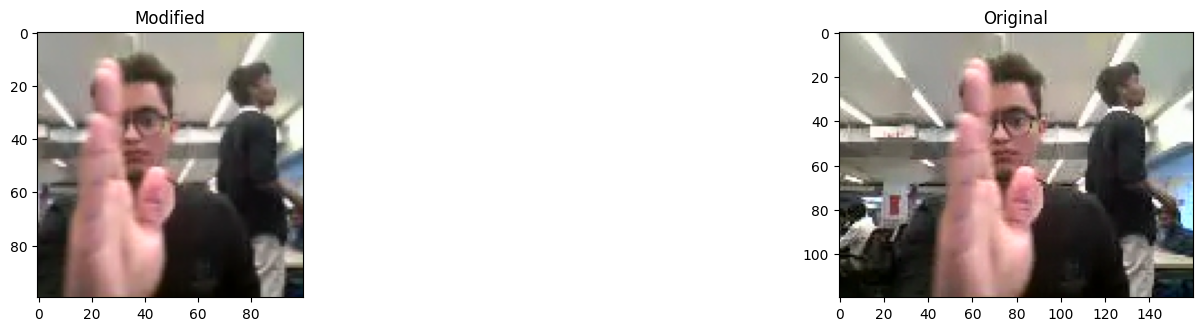

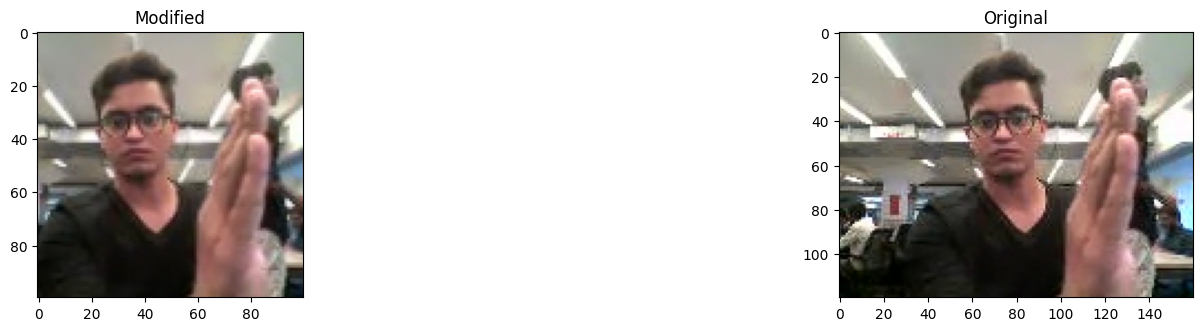

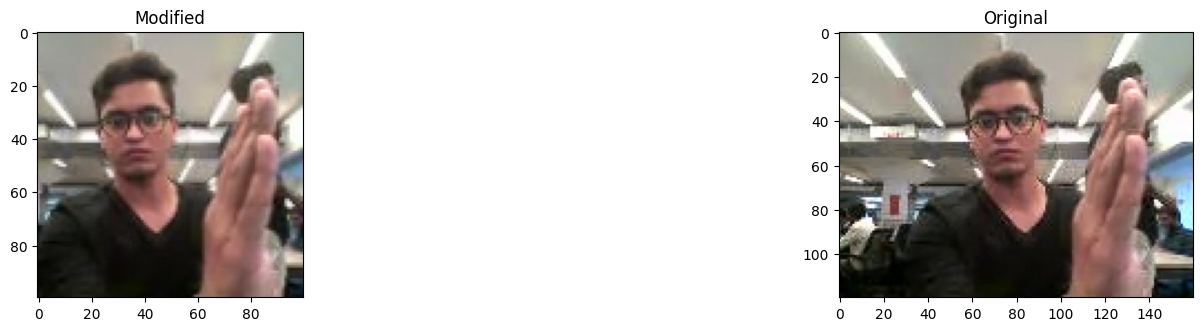

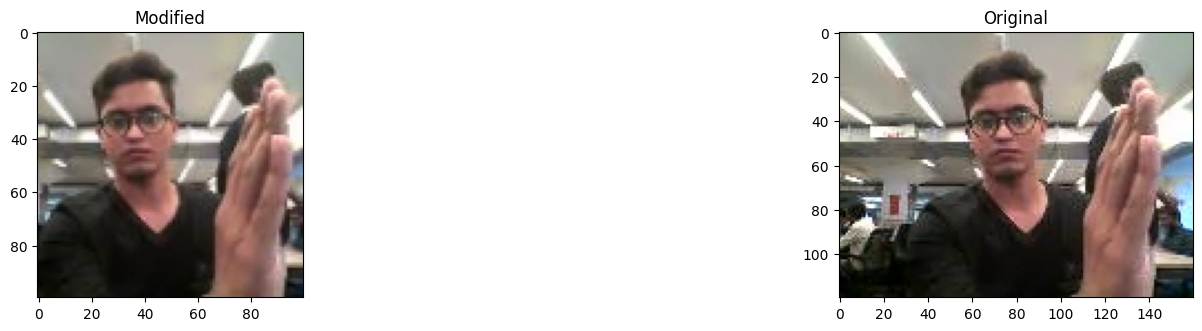

In [8]:
paths = ["/kaggle/input/smart-tv-gesture-recognition/Project_data/train/WIN_20180925_17_24_26_Pro_Right_Swipe_new/WIN_20180925_17_24_26_Pro_00031.png",
"/kaggle/input/smart-tv-gesture-recognition/Project_data/train/WIN_20180925_17_24_26_Pro_Right_Swipe_new/WIN_20180925_17_24_26_Pro_00018.png",
"/kaggle/input/smart-tv-gesture-recognition/Project_data/train/WIN_20180925_17_24_26_Pro_Right_Swipe_new/WIN_20180925_17_24_26_Pro_00016.png",
"/kaggle/input/smart-tv-gesture-recognition/Project_data/train/WIN_20180925_17_24_26_Pro_Right_Swipe_new/WIN_20180925_17_24_26_Pro_00012.png"]

show_resize_crop_image(paths)

In [9]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_crop_image(image)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)

            for batch in range(batch_size): # we iterate over the number of batches
                batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        #crop the images and resize them. Note that the images are of 2 different shape
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image = resize_crop_image(image)

                        batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [10]:
curr_dt_time = datetime.datetime.now()
train_path = '/kaggle/input/smart-tv-gesture-recognition/Project_data/train'
val_path = '/kaggle/input/smart-tv-gesture-recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


### Experiment 1

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [12]:
optimizer = optimizers.SGD(learning_rate=0.001, momentum=0.7, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 100, 100, 8)   656       
                                                                 
 batch_normalization (Batch  (None, 15, 100, 100, 8)   32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 15, 100, 100, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 7, 50, 50, 8)      0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 50, 50, 16)     3472      
                                                                 
 batch_normalization_1 (Bat  (None, 7, 50, 50, 16)     6

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'model_init_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [16]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/smart-tv-gesture-recognition/Project_data/train ; batch size = 8
Epoch 1/25


I0000 00:00:1708811984.252817     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


83/83 [==============================] - ETA: 0s - loss: 1.7228 - categorical_accuracy: 0.2443Source path =  /kaggle/input/smart-tv-gesture-recognition/Project_data/val ; batch size = 8

Epoch 1: val_loss improved from inf to 1.68555, saving model to model_init_2024-02-2421_59_37.839721/model-00001-1.72279-0.24434-1.68555-0.24000.h5
83/83 [==============================] - 136s 2s/step - loss: 1.7228 - categorical_accuracy: 0.2443 - val_loss: 1.6856 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
 3/83 [>.............................] - ETA: 3s - loss: 1.4569 - categorical_accuracy: 0.4762

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - ETA: 0s - loss: 1.5730 - categorical_accuracy: 0.2685
Epoch 2: val_loss improved from 1.68555 to 1.47423, saving model to model_init_2024-02-2421_59_37.839721/model-00002-1.57299-0.26850-1.47423-0.36538.h5
83/83 [==============================] - 82s 994ms/step - loss: 1.5730 - categorical_accuracy: 0.2685 - val_loss: 1.4742 - val_categorical_accuracy: 0.3654 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 1.5553 - categorical_accuracy: 0.2628
Epoch 3: val_loss improved from 1.47423 to 1.45361, saving model to model_init_2024-02-2421_59_37.839721/model-00003-1.55533-0.26281-1.45361-0.38462.h5
83/83 [==============================] - 61s 745ms/step - loss: 1.5553 - categorical_accuracy: 0.2628 - val_loss: 1.4536 - val_categorical_accuracy: 0.3846 - lr: 0.0010
Epoch 4/25
83/83 [==============================] - ETA: 0s - loss: 1.5363 - categorical_accuracy: 0.2506
Epoch 4: val_loss did not improve from 1.45361
83/8

**Training Accuracy:** 0.34%

**Validation Accuracy:** 0.54%

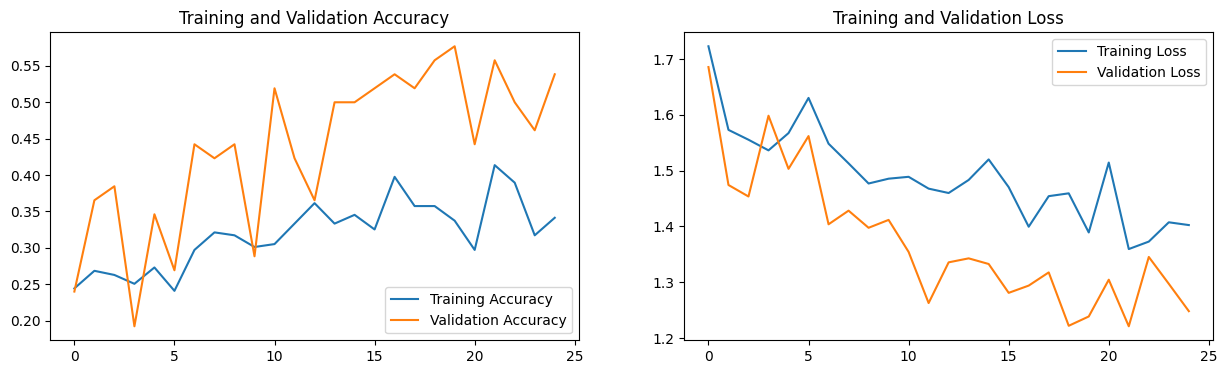

In [17]:
from IPython.display import Markdown, display

def plot_history(history):
    display(Markdown("**Training Accuracy:** " + str(round(history.history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
    display(Markdown("**Validation Accuracy:** " + str(round(history.history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))

    #print("Training Accuracy:" + history.history['categorical_accuracy'][num_epochs-1])
    #print("Validation Accuracy:" + history.history['val_categorical_accuracy'][num_epochs-1])

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

### Experiment 2

Reducing the size of the image from 50 to 25

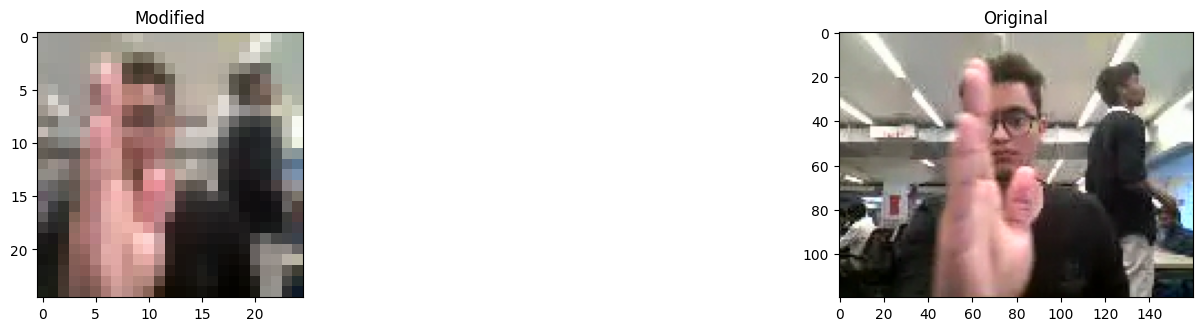

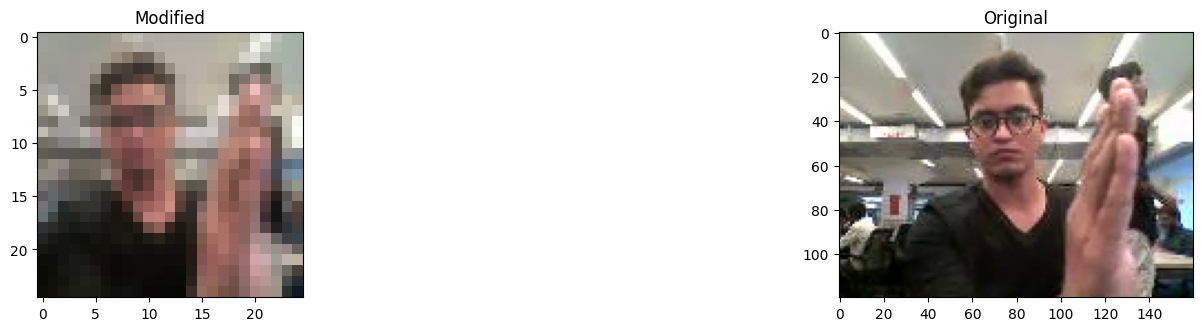

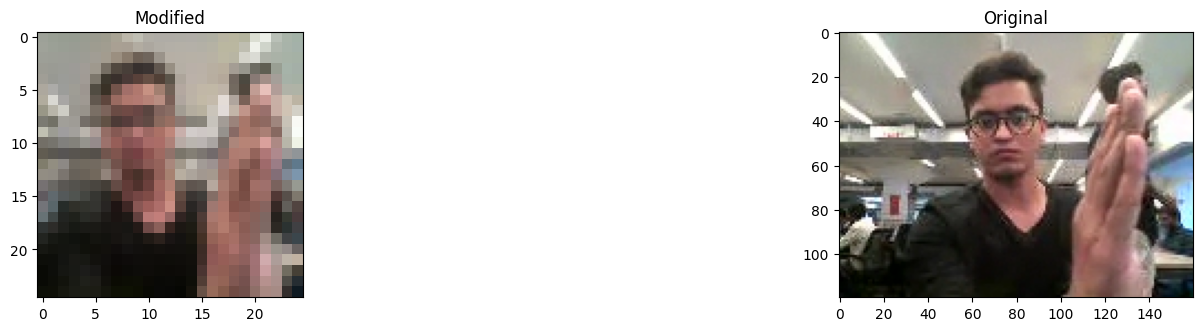

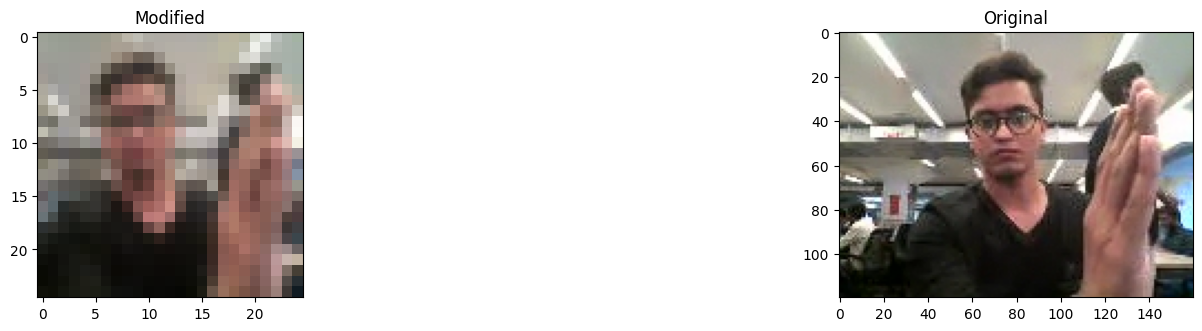

In [18]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 25
image_width = 25
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

show_resize_crop_image(paths)

In [19]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [22]:
from tensorflow.keras.optimizers import legacy

optimiser = legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 25, 25, 8)     656       
                                                                 
 batch_normalization_3 (Bat  (None, 15, 25, 25, 8)     32        
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 15, 25, 25, 8)     0         
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 7, 12, 12, 8)      0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 12, 12, 16)     3472      
                                                                 
 batch_normalization_4 (Bat  (None, 7, 12, 12, 16)    

In [23]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [24]:
model_name = 'model_exp3_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [25]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [26]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/smart-tv-gesture-recognition/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.8479 - categorical_accuracy: 0.2443Source path =  /kaggle/input/smart-tv-gesture-recognition/Project_data/val ; batch size = 8

Epoch 1: val_loss improved from inf to 1.56618, saving model to model_exp3_2024-02-2421_59_37.839721/model-00001-1.84792-0.24434-1.56618-0.26000.h5
83/83 [==============================] - 85s 1s/step - loss: 1.8479 - categorical_accuracy: 0.2443 - val_loss: 1.5662 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.5707 - categorical_accuracy: 0.2771
Epoch 2: val_loss improved from 1.56618 to 1.51535, saving model to model_exp3_2024-02-2421_59_37.839721/model-00002-1.57074-0.27711-1.51535-0.30769.h5
83/83 [==============================] - 67s 812ms/step - loss: 1.5707 - categorical_accuracy: 0.2771 - val_loss: 1.5153 - val_categoric

**Training Accuracy:** 0.44%

**Validation Accuracy:** 0.56%

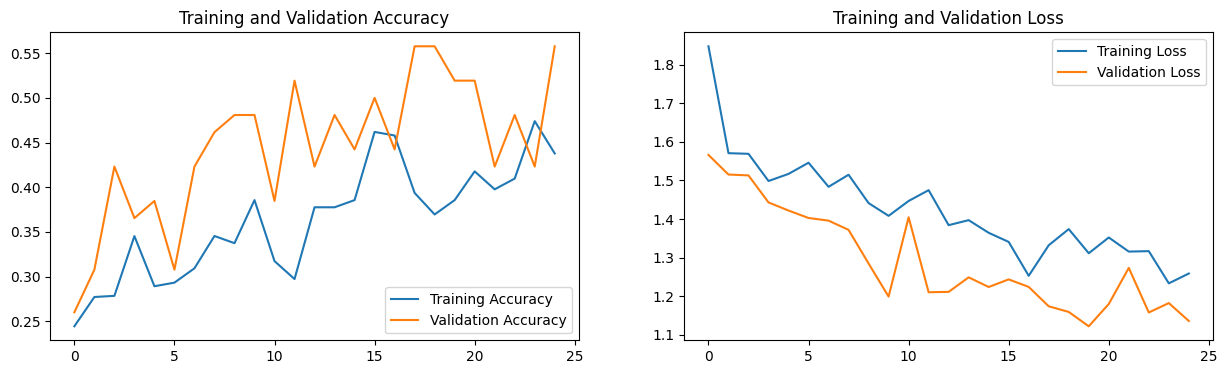

In [27]:
plot_history(history)

<b>Conclusion:</b> Scaling from 50 to 25 reduced the training and validation accuracy

### Experiment 3

Decreasing the batch size from 8 to 4

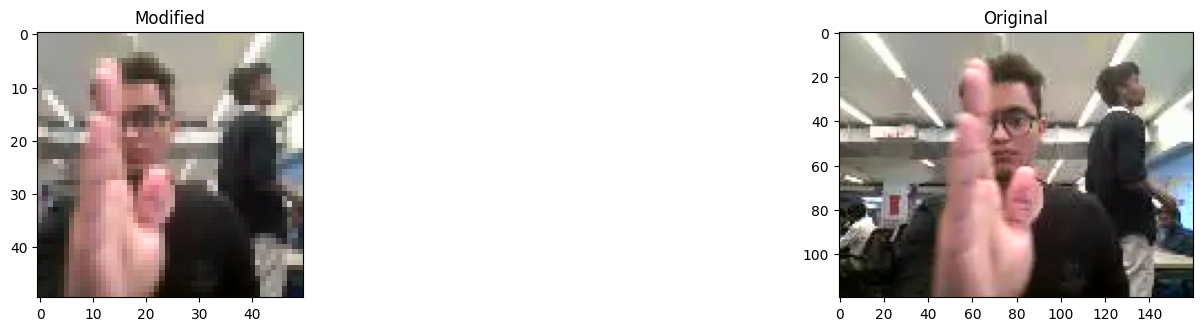

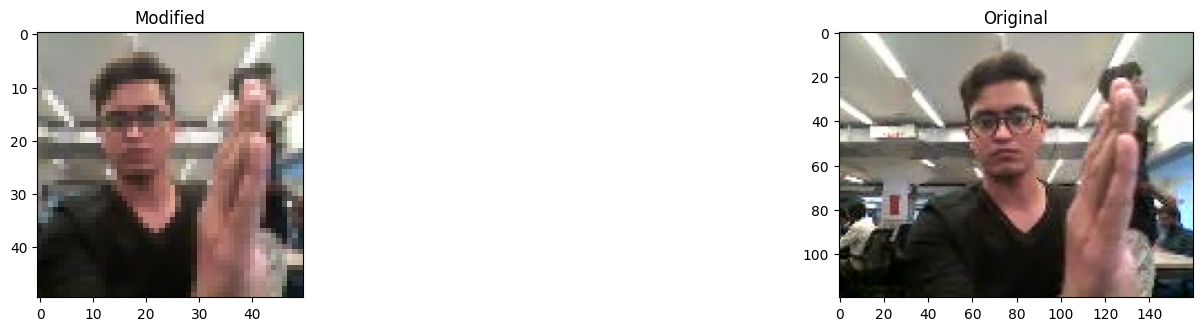

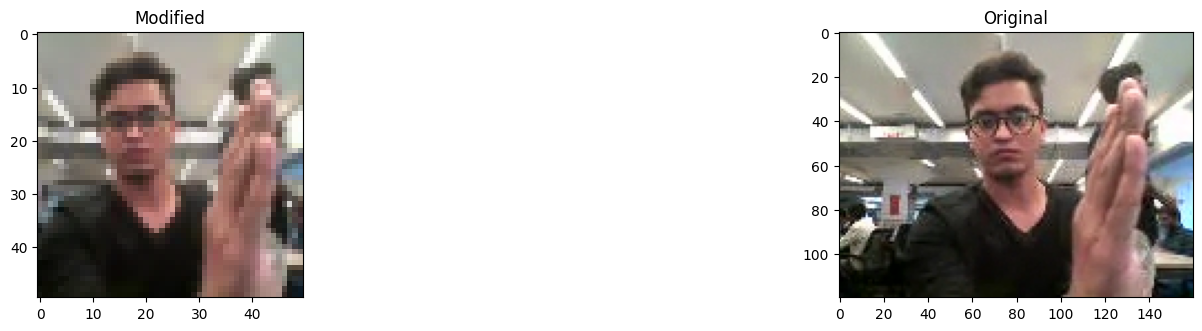

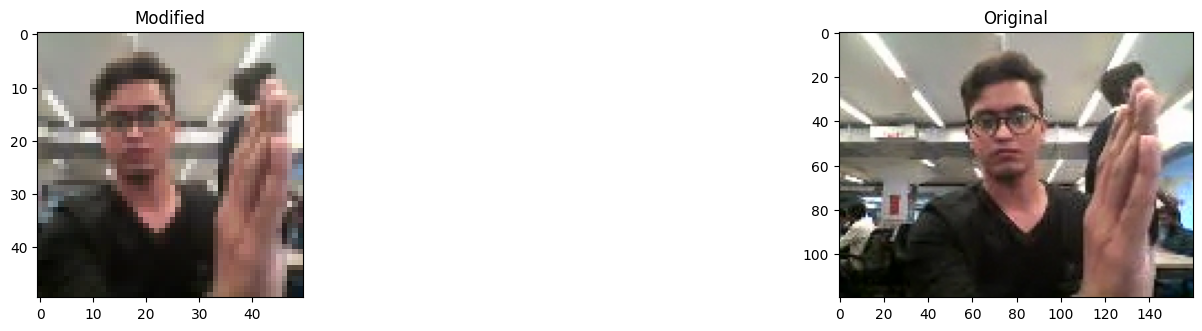

In [28]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

show_resize_crop_image(paths)

In [29]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [30]:

from tensorflow.keras.optimizers import legacy

optimiser = legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_6 (Bat  (None, 15, 50, 50, 8)     32        
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 7, 25, 25, 8)      0         
 g3D)                                                            
                                                                 
 conv3d_7 (Conv3D)           (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_7 (Bat  (None, 7, 25, 25, 16)    

In [31]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [32]:
model_name = 'model_exp4_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [33]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [34]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/smart-tv-gesture-recognition/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.7341 - categorical_accuracy: 0.2534Source path =  /kaggle/input/smart-tv-gesture-recognition/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.54506, saving model to model_exp4_2024-02-2421_59_37.839721/model-00001-1.73409-0.25339-1.54506-0.24000.h5
166/166 [==============================] - 86s 517ms/step - loss: 1.7341 - categorical_accuracy: 0.2534 - val_loss: 1.5451 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.5815 - categorical_accuracy: 0.2490
Epoch 2: val_loss improved from 1.54506 to 1.53077, saving model to model_exp4_2024-02-2421_59_37.839721/model-00002-1.58148-0.24900-1.53077-0.44000.h5
166/166 [==============================] - 66s 397ms/step - loss: 1.5815 - categorical_accuracy: 0.2490 - val_loss: 1.5308 - va

**Training Accuracy:** 0.51%

**Validation Accuracy:** 0.66%

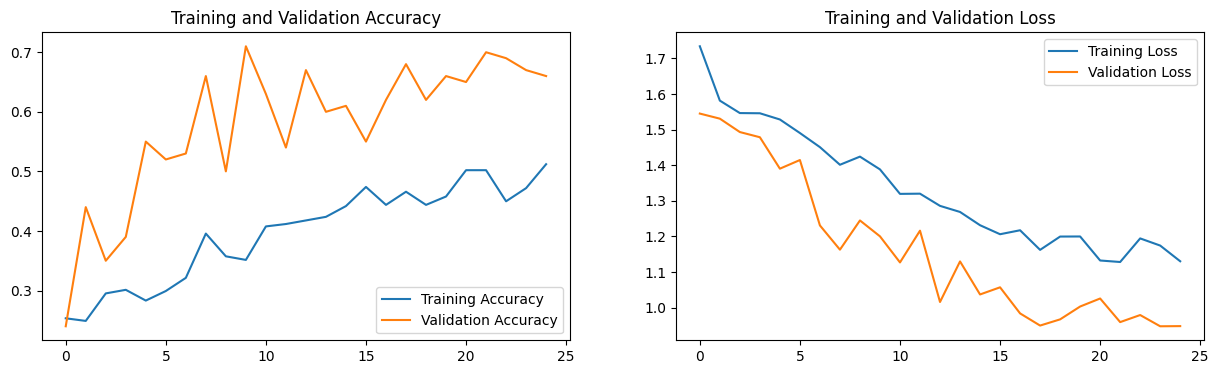

In [35]:
plot_history(history)

<b>Conclusion:</b> Reducing the batch size has reduced overfitting

### Experiment 4
Changing the optmizer from `SGD` to `Adam`

In [36]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs=25

img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

In [37]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_9 (Bat  (None, 15, 50, 50, 8)     32        
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_9 (MaxPoolin  (None, 7, 25, 25, 8)      0         
 g3D)                                                            
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_10 (Ba  (None, 7, 25, 25, 16)    

In [38]:


optimiser = legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_9 (Bat  (None, 15, 50, 50, 8)     32        
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_9 (MaxPoolin  (None, 7, 25, 25, 8)      0         
 g3D)                                                            
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_10 (Ba  (None, 7, 25, 25, 16)    

In [39]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [40]:
model_name = 'model_exp5_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [41]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [42]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/smart-tv-gesture-recognition/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.7512 - categorical_accuracy: 0.2579Source path =  /kaggle/input/smart-tv-gesture-recognition/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.57077, saving model to model_exp5_2024-02-2421_59_37.839721/model-00001-1.75119-0.25792-1.57077-0.23000.h5
166/166 [==============================] - 85s 513ms/step - loss: 1.7512 - categorical_accuracy: 0.2579 - val_loss: 1.5708 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6143 - categorical_accuracy: 0.2510
Epoch 2: val_loss improved from 1.57077 to 1.50212, saving model to model_exp5_2024-02-2421_59_37.839721/model-00002-1.61426-0.25100-1.50212-0.31000.h5
166/166 [==============================] - 65s 392ms/step - loss: 1.6143 - categorical_accuracy: 0.2510 - val_loss: 1.5021 - va

**Training Accuracy:** 0.59%

**Validation Accuracy:** 0.68%

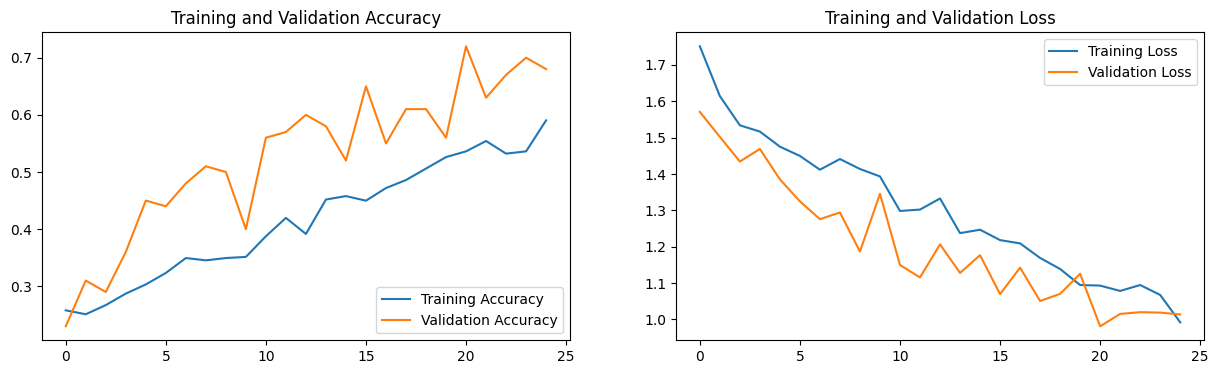

In [43]:
plot_history(history)

<b>Conclusion:</b> `Adam` has reduced overfitting. However since the accuracy has been constantly improving we might need to increase the number of epochs in a later experiment

### Experiment 5

Reducing the number of frames from 15 to 10

and Reducing the dropout rate from 0.5 to 0.25

Increasing the number of epochs from 25 to 35

In [44]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=35

In [45]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_12 (Ba  (None, 10, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 5, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_13 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_13 (Ba  (None, 5, 25, 25, 16)    

In [46]:


optimiser = legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_12 (Ba  (None, 10, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 5, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_13 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_13 (Ba  (None, 5, 25, 25, 16)    

In [47]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [48]:
model_name = 'model_exp8_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [49]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [50]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/smart-tv-gesture-recognition/Project_data/train ; batch size = 4
Epoch 1/35
166/166 [==============================] - ETA: 0s - loss: 1.6495 - categorical_accuracy: 0.2459Source path =  /kaggle/input/smart-tv-gesture-recognition/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.54031, saving model to model_exp8_2024-02-2421_59_37.839721/model-00001-1.64949-0.24585-1.54031-0.31000.h5
166/166 [==============================] - 76s 456ms/step - loss: 1.6495 - categorical_accuracy: 0.2459 - val_loss: 1.5403 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/35
166/166 [==============================] - ETA: 0s - loss: 1.5384 - categorical_accuracy: 0.3012
Epoch 2: val_loss did not improve from 1.54031
166/166 [==============================] - 45s 272ms/step - loss: 1.5384 - categorical_accuracy: 0.3012 - val_loss: 1.5830 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/35
166/166 [==============================] - ETA: 0s

**Training Accuracy:** 0.76%

**Validation Accuracy:** 0.73%

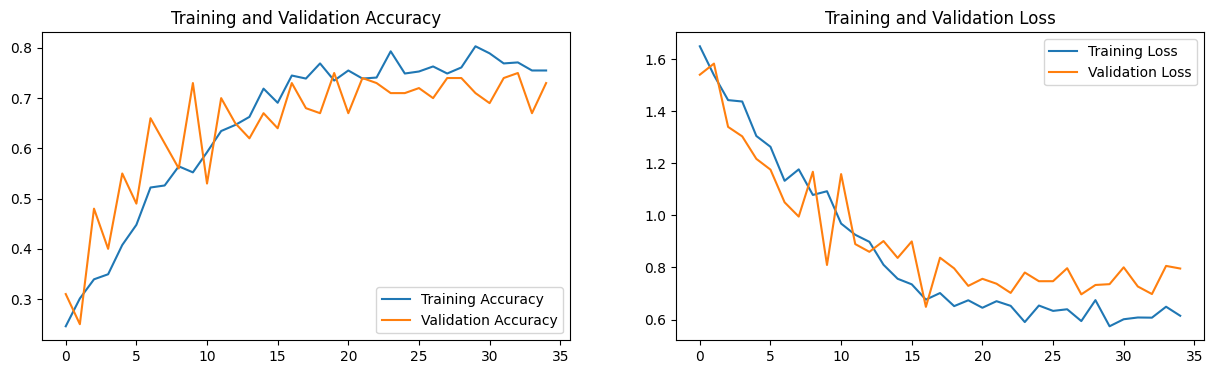

In [51]:
plot_history(history)

In [52]:
model.save("Smart_TV_Gesture_Recognition.h5")